# ODE module testing

## Bindings testing

First set `Python` to look for python integrated modules in the parent folder.

In [1]:
# DYNAMIC PATH SELECTION TO IMPORT THE MODULES
import sys
import os
from pathlib import Path

notebook_path = Path(os.path.abspath('')).resolve()

# Construct the paths to the required directories
modules_path = os.path.join(notebook_path, '..')
ode_path = os.path.join(modules_path, 'ODE')

# Add the directories to the Python path if they're not already there
if modules_path not in sys.path:
    sys.path.append(modules_path)
if ode_path in sys.path:
    sys.path.append(ode_path)

Now we can safely import the `ODE` module binded from `C++` and enriched with new functionalities.

In [2]:
from python_modules.ODE import ODEModule as ODE
import numpy as np
import matplotlib.pyplot as plt

## Test Bindings

In order to test functionality of some bindings, we have first to define some differential problems. For this examples, we provide an ODE with a close solution (expressable in an analytical way), in order to test functionalities like `computeInfinityError` or `computeEmpiricalOrder`, while we provide an ODE without an analytical solution (Lotks-Volterra problem), in order to test functionalities of plots, made in `Python`, and other functionalities, like writeCSV.

In [3]:
# Define the ODE
def df(t, y):
    dydt = np.zeros(2)
    dydt[0] = y[1]   # dy0/dt = y1
    dydt[1] = -y[0]  # dy1/dt = -y0
    return dydt

# Define the exact solution
def f(t):
    y = np.zeros(2)
    y[0] = np.cos(t)
    y[1] = -np.sin(t)
    return y

#Define the initial conditions
t0 = 0.0
tf = 10.0
y0 = [1.0, 0.0]

### Test of `solve`

In [4]:
solver1 = ODE.method('ForwardEuler',df)
solver2 = ODE.method('RK4', df)
solver3 = ODE.method('MidPoint',df)

In [5]:
# Solve the ODE
solver1.solve(t0, tf, y0, 100)
solver2.solve(t0, tf, y0, 100)
solver3.solve(t0, tf, y0, 100)

# Return the results
times = solver1.timeSteps
solution = solver1.solSteps
print(f'Time steps: {times}')
print(f'Solution steps: {solution}')

Time steps: [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7, 0.7999999999999999, 0.8999999999999999, 0.9999999999999999, 1.0999999999999999, 1.2, 1.3, 1.4000000000000001, 1.5000000000000002, 1.6000000000000003, 1.7000000000000004, 1.8000000000000005, 1.9000000000000006, 2.0000000000000004, 2.1000000000000005, 2.2000000000000006, 2.3000000000000007, 2.400000000000001, 2.500000000000001, 2.600000000000001, 2.700000000000001, 2.800000000000001, 2.9000000000000012, 3.0000000000000013, 3.1000000000000014, 3.2000000000000015, 3.3000000000000016, 3.4000000000000017, 3.5000000000000018, 3.600000000000002, 3.700000000000002, 3.800000000000002, 3.900000000000002, 4.000000000000002, 4.100000000000001, 4.200000000000001, 4.300000000000001, 4.4, 4.5, 4.6, 4.699999999999999, 4.799999999999999, 4.899999999999999, 4.999999999999998, 5.099999999999998, 5.1999999999999975, 5.299999999999997, 5.399999999999997, 5.4999999999999964, 5.599999999999996, 5.699999999999996, 5.799999999999995, 5.8999999

`times` and `solutions` steps are returned as lists, and in the latter case, as a list of `numpy.array`s, as in C++ they were treated as `Eigen::Vector`s. It's quite a sad output, but later will be shown a functionality added in Python to display various plots.

### Test of other bindings

From now on, we will focus on the second solver, as it allows for an higher precision.

In [6]:
# Test of method to export solution to csv file
solver1.writeCSV('../solutions/ForwardEuler.csv')
solver2.writeCSV('../solutions/RK4.csv')
solver3.writeCSV('../solutions/MidPoint.csv')

As we are dealing with an ODE with analytical solution, we can compute the Infinity Norm Error and the empirical order of convergence.

In [7]:
solver2.computeInfinityNormError(f)

7.965460030179283e-06

In [8]:
euler_order=solver1.computeEmpiricalOrder(t0,tf, y0, 100,f)
rk4_order=solver2.computeEmpiricalOrder(t0,tf, y0, 100,f)
midp_order=solver3.computeEmpiricalOrder(t0,tf, y0, 100,f)
print(f'Euler empirical order: {euler_order}')
print(f'RK4 empirical order: {rk4_order}')
print(f'MidPoint empirical order: {midp_order}')

Euler empirical order: 1.0996835689369502
RK4 empirical order: 4.00341523214585
MidPoint empirical order: 2.0028804867762346


### Test execution time

As a benchmark, we can try and measure the execution time of the solve function, in order to have a comparison between a direct measurment in C++, and the measurment Python does when calling a function.
For this purpose, we can use `singleExeTime` and `meanExeTime` methods, developed in C++ and binded to python, and the measure of time through a call from python, using the custom decorator `@time_execution`.

In [9]:
print(f'Mean execution time of RK4 in C++: {solver2.meanExeTime(t0, tf, y0, 100)} microseconds')
solver2.chrono_solve(t0, tf, y0, 100)

Mean execution time of RK4 in C++: 2503.18 microseconds
chrono_solve executed in time: 5050.897598266602 microseconds


### Test of custom `help()` bindings

Just a quick display of the docstrings implemented in the bindings

In [10]:
print(help(ODE.ExplicitODESolver.solve))

Help on instancemethod in module ODE:

solve(...)
    solve(self: ODE.ExplicitODESolver, t0: float, tf: float, y0: numpy.ndarray[numpy.float64[m, 1]], num_steps: int) -> None
    
    Solve the ODE using the Butcher tableau and store time and solution vectors
                
                Parameters:
                    t0 (float): Initial time
                    tf (float): Final time
                    y0 (list or numpy.array): Initial condition
                    num_steps (int): Number of steps to  (it has to be a positive integer)
                
                Returns:
                    void

None


## Test of custom `Python` methods

Now we approach to test the functionality of the module added thanks to Python.
We mainly focussed on implementing some plots of solution, trajectory and errors.
First plot the function used above.

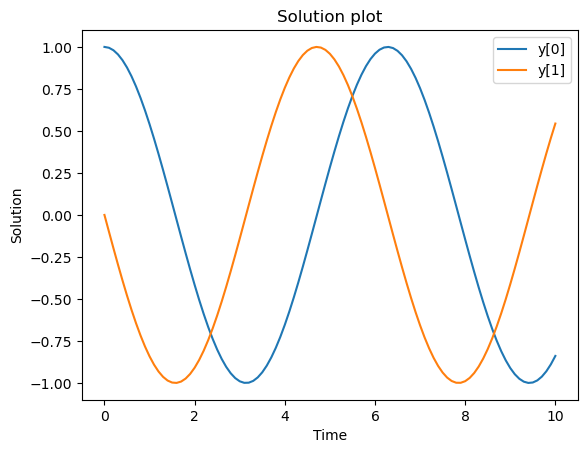

In [11]:
solver2.plotSolution()
plt.legend(['y[0]', 'y[1]'])
plt.show()

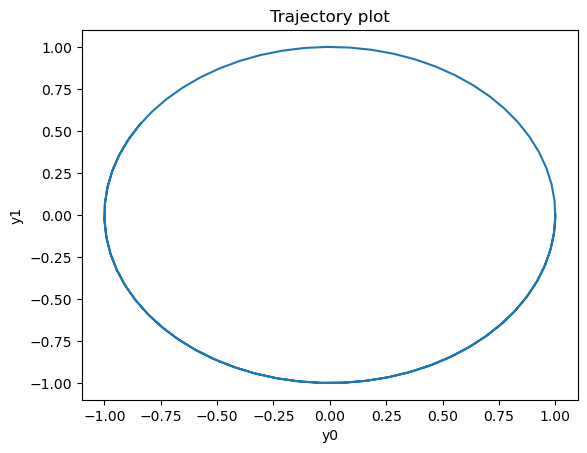

In [12]:
solver2.plotTrajectory()
plt.show()

Concerning error plots, it's sensible to plot the errors relative to the three methods, in order to apreciate their precision.

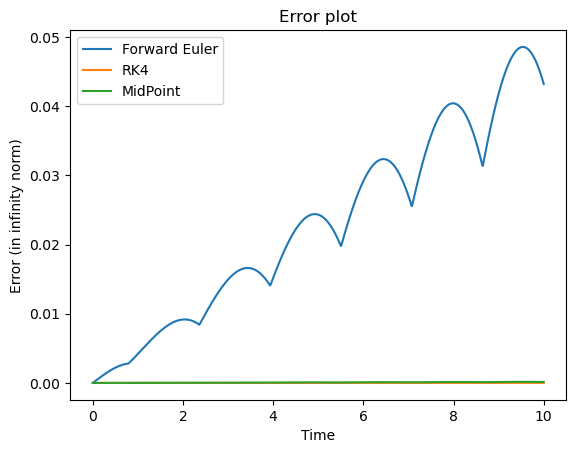

In [13]:
solver1.plotError(f)
solver2.plotError(f)
solver3.plotError(f)
plt.legend(['Forward Euler', 'RK4', 'MidPoint'])
plt.show()

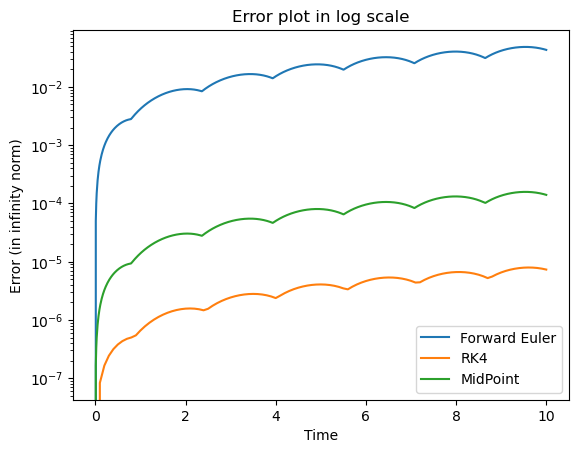

In [14]:
solver1.plotLogError(f)
solver2.plotLogError(f)
solver3.plotLogError(f)
plt.legend(["Forward Euler", "RK4", "MidPoint"])
plt.show()

To showcase the functionality of the module, we can solve and ODE without an explicit solution, and plot its trajectory.
For this purpose we are solving the Lotka-Volterra equations, relative to the prey-predator population evolution.

In [15]:
# Lotka-Volterra equations
def lotka_volterra(t, y):
    dydt = np.zeros(2)
    dydt[0] = 0.1 * y[0] - 0.02 * y[0] * y[1]
    dydt[1] = 0.03 * y[0] * y[1] - 0.1 * y[1]
    return dydt

In order to achieve better precision we are focussing on the RK4 method, and we are providing two different initial conditions.

In [16]:
solveLV1 = ODE.method('RK4', lotka_volterra)
solveLV2 = ODE.method('RK4', lotka_volterra)

In [17]:
solveLV1.solve(0, 500, [40/49, 9/49], 1000)
solveLV2.solve(0, 500, [30/49, 19/49], 1000)

Now some plots.

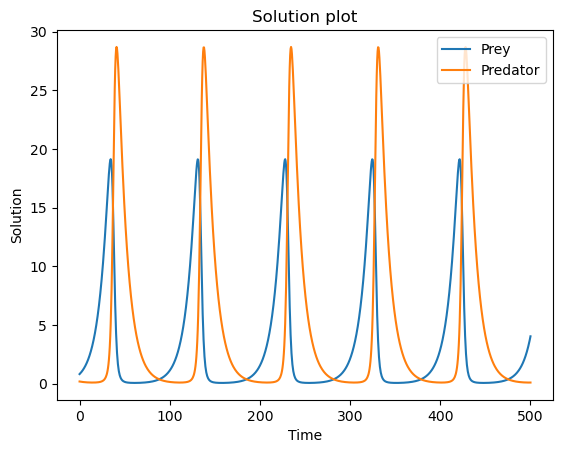

In [18]:
solveLV1.plotSolution()
plt.legend(['Prey', 'Predator'])
plt.show()

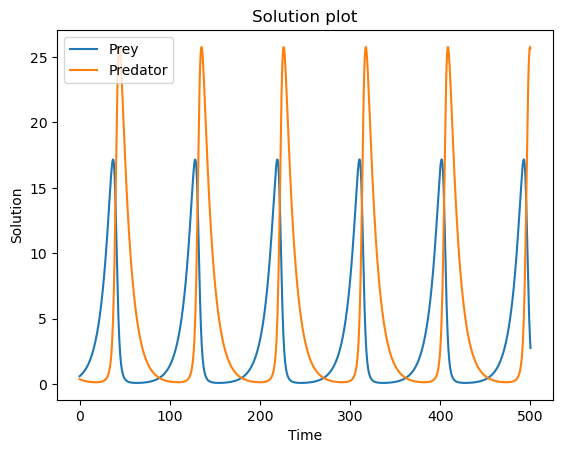

In [19]:
solveLV2.plotSolution()
plt.legend(['Prey', 'Predator'])
plt.show()

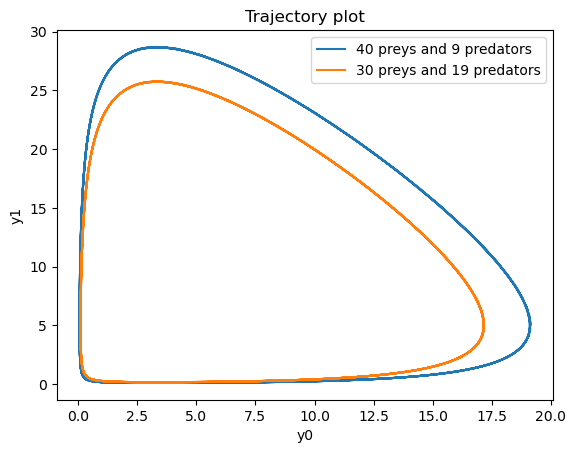

In [20]:
solveLV1.plotTrajectory()
solveLV2.plotTrajectory()
plt.legend(["40 preys and 9 predators", "30 preys and 19 predators"])
plt.show()